# initialization

In [1]:
# @title imports and pip install

# !pip install sentence_transformers
# !pip install util
# from sentence_transformers import SentenceTransformer, util

from google.colab import drive
drive.mount('/content/drive')
import pickle
import os
import re
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import BartTokenizer, BartForConditionalGeneration

# Mount to google drive

Mounted at /content/drive


In [6]:
# @title model names and general variables

# so far we have BART and T5 models
model_bart_name = 'facebook/bart-base'
model_t5_name = "t5-large"
model_names_dict = {"BART": model_bart_name, "T5": model_t5_name}

model_selection = [1, 1]

drive_path_for_datasets = '/content/drive/MyDrive/Projects/CryptoniteAnalysis/datasets'
drive_path_for_indicators = '/content/drive/MyDrive/Projects/CryptoniteAnalysis/EnsembleMethods/indicatores/indicators.pkl'


In [ ]:
# @title supporting function to load pretrained models
# Function to load different models based on a condition
def load_model(model_name):
    if "BART" == model_name:
        return BartForConditionalGeneration.from_pretrained(model_names_dict[model_name])
    elif "T5" == model_name:
        return T5ForConditionalGeneration.from_pretrained(model_names_dict[model_name])

#can add more models
    else:
        return AutoModelForSeq2SeqLM.from_pretrained(model_names_dict[model_name])

# Function to load different tokenizers based on a condition
def load_tokenizer(model_name):
    if "BART" == model_name:
        return BartTokenizer.from_pretrained(model_names_dict[model_name])
    elif "T5" == model_name:
        return T5Tokenizer.from_pretrained(model_names_dict[model_name])

#can add more models
    else:
        return AutoTokenizer.from_pretrained(model_names_dict[model_name])


In [ ]:
# @title load pretrained models
# Create a new dictionary with the selected models and their tokenizers
# Create a new dictionary with the selected models and their tokenizers
selected_models = {
    key: {
        "model": load_model(key),
        "tokenizer": load_tokenizer(key)
    }
    for key in model_names_dict.keys() if model_selection[list(model_names_dict.keys()).index(key)] == 1
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# prediction

In [ ]:
# @title supporting function for prediction

def count_digits_in_parentheses(s):
    import re
    # Extract digits within parentheses
    digits = re.findall(r'\d', s)
    # Return the count of digits
    return len(digits)

def get_first_x_words(s, x):
    # Split the string into words
    words = s.split()
    # Get the first x words
    first_x_words = words[:x]
    # Join the words back into a single string
    result = ' '.join(first_x_words)
    return result

In [ ]:
# @title basic function for prediction

def get_model_pred(model_name, clue_sentence, len_of_response):

  if model_name not in selected_models.keys():
    error_message = "model " + model_name + " wasn't loaded"
    print(error_message)
    return None


  response = ""
  model = selected_models[model_name]["model"]
  tokenizer = selected_models[model_name]["tokenizer"]

    # TODO add the function
  input_ids = tokenizer.encode(clue_sentence, return_tensors="pt", max_length=512, truncation=True)

  output = model.generate(input_ids, max_new_tokens=len_of_response)

  response = tokenizer.decode(output[0], skip_special_tokens=True)

  return get_first_x_words(response, len_of_response)

def calculate_confidence_from_scores(scores):
    # TODO check if the best approach
    import torch
    avg_log_prob = torch.mean(torch.stack(scores), dim=0)
    confidence = torch.exp(avg_log_prob).mean().item()
    return confidence

def get_model_pred_with_score(model_name, clue_sentence, len_of_response, score_type="confidence"):
    if model_name not in selected_models.keys():
        error_message = "model " + model_name + " wasn't loaded"
        print(error_message)
        return None, None

    model = selected_models[model_name]["model"]
    tokenizer = selected_models[model_name]["tokenizer"]

    input_ids = tokenizer.encode(clue_sentence, return_tensors="pt", max_length=512, truncation=True)
    # output = model.generate(input_ids, max_new_tokens=len_of_response, output_scores=True, return_dict_in_generate=True)
    output = model.generate(input_ids, output_scores=True, return_dict_in_generate=True)

    response_ids = output.sequences[0]
    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    scores = output.scores

    if score_type == "confidence":
      # Assuming the confidence is calculated from the logits/probabilities
      return_score = calculate_confidence_from_scores(scores)
    elif  score_type == "ML_approach":
      # TODO add the implementation
      pass

    # print("response before cutting: " + response)
    # response_after = get_first_x_words(response, len_of_response)
    # print("response after cutting: " + response_after)

    return get_first_x_words(response, len_of_response), return_score



In [ ]:
# @title some code for reading the data and predictint - MIGHT change later
# json file

df = pd.DataFrame(columns=["text", "label"])
# Opening JSON file
file_path = '/content/drive/MyDrive/CryptoniteAnalysis/datasets/cryptonite-official-split/cryptonite-train.jsonl'
for model in model_names:
  i = 0

  print("\n\n")

  print("For model: " + model + "\n\n")

  with open(file_path, 'r') as file:
          for line in file:
              # Parse the JSON object from the line
              data = json.loads(line)
              clue_sentence = "For the clue: " + data["clue"] + "\nThe answer is:"

              true_ans = data["answer"]
              pred_ans = get_model_pred(model, clue_sentence, count_digits_in_parentheses(data["enumeration"])+20)
              print("The clue is: ", data["clue"])
              print("pred_ans: ", pred_ans, "\n")
              embedding_true_ans = model_for_sim.encode(true_ans)
              embedding_pred_ans = model_for_sim.encode(pred_ans)
              cosine_similarity = util.cos_sim(embedding_true_ans, embedding_pred_ans).item()

              df.loc[len(df)] = [clue_sentence, cosine_similarity]

              i  = i + 1
              if i == 3:
                break

print(df)

# Ensemble

In [ ]:
# @title ensemble by weight/score

# for majority voting, just send the same number for stats.
def get_best_model_response_by_model_scores(selected_models, clue, scores, len_of_response):
    responses = []
    for model_name, model_info in selected_models.items():
        response = get_model_pred(model_name, clue, len_of_response)
        responses.append((model_name, response))

    # Initialize a dictionary to store the sum of scores for each response
    response_scores = {}

    for i, (model_name, response) in enumerate(responses):
        if response not in response_scores:
            response_scores[response] = 0
        response_scores[response] += scores[i]

    # Find the response with the highest score
    best_response = max(response_scores, key=response_scores.get)

    # Find the models that contributed to the best response
    contributing_models = [model_name for model_name, response in responses if response == best_response]

    return best_response, contributing_models

def get_best_model_response_by_response_score(selected_models, clue, len_of_response, score_type="confidence"):
    responses_with_confidence = []
    for model_name, model_info in selected_models.items():
        response, confidence = get_model_pred_with_score(model_name, clue, len_of_response, score_type)
        # print("model: " + model_name + " response: " + response + " confidence: " + str(confidence))
        responses_with_confidence.append((model_name, response, confidence))

    # Find the response with the highest confidence
    best_response_data = max(responses_with_confidence, key=lambda x: x[2])
    best_response = best_response_data[1]

    # Find the models that contributed to the best response
    contributing_models = [model_name for model_name, response, confidence in responses_with_confidence if response == best_response]

    # If only one model contributed to the best response, return that model
    if len(contributing_models) == 1:
        contributing_models = contributing_models[0]

    return best_response, contributing_models

# main code

In [7]:
# @title loading the data

train_fp = drive_path_for_datasets + '/cryptonite-official-split/cryptonite-train.jsonl'
val_fp = drive_path_for_datasets + "/cryptonite-official-split/cryptonite-val.jsonl"
test_fp = drive_path_for_datasets + '/cryptonite-official-split/cryptonite-test.jsonl'

# Read the JSON Lines file into a DataFrame
df_train = pd.read_json(train_fp, lines=True)
df_val = pd.read_json(val_fp, lines=True)
df_test = pd.read_json(test_fp, lines=True)


<ipython-input-7-12a890bf7041>:8: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_train = pd.read_json(train_fp, lines=True)


ValueError: Expected object or value

In [ ]:
# @title some helping functions

def count_digits_in_parentheses(s):
    import re
    # Extract digits within parentheses
    digits = re.findall(r'\d', s)
    # Return the count of digits
    return len(digits)

def parse_clue(clue_string):
    # Split the string into the clue part and the numbers part
    match = re.match(r"(.+)\(([\d,]+)\)", clue_string)
    if not match:
        return "Invalid input format."

    clue = match.group(1).strip()
    numbers = match.group(2).strip()

    # Split the numbers part into individual word lengths
    word_lengths = [int(num) for num in numbers.split(',')]
    num_words = len(word_lengths)

    # Construct the output
    output = f"For the clue: {clue}.\n"
    output += f"The answer contains {num_words} word{'s' if num_words > 1 else ''}.\n"
    for i, length in enumerate(word_lengths):
        output += f"The length of the {'first' if i == 0 else 'second' if i == 1 else 'third' if i == 2 else str(i+1)+'th'} word is {length}. \n"
    output += "The answer is:\n"

    return output

In [ ]:
# @title add column for predicting by confidence
def process_row_by_confidence(row):

    answer = row['answer']
    len_of_response = count_digits_in_parentheses(row["enumeration"])
    # print("len_of_response: " + str(len_of_response))
    clue = row['clue']
    # clue_sentence = "For the clue: " + clue + ". \nThe answer contains " + str(len_of_response) + " words. \nThe answer is:"
    clue_sentence = parse_clue(clue)

    # print("clue: " + clue_sentence + "\n\n")

    best_response, contributing_models = get_best_model_response_by_response_score(selected_models, clue, len_of_response, score_type="confidence")
    # print("best response: " + str(best_response))
    # print("contributing models: " + str(contributing_models))
    # print("\n\n")

    # If there's only one model that contributed, wrap it in a list
    if isinstance(contributing_models, str):
        contributing_models = [contributing_models]

    for model in contributing_models:
      # TODO maybe we should use other comparison
        row[f"{model} by confidence"] = 1 if best_response == answer else 0

    return row

In [ ]:
%pdb off

Automatic pdb calling has been turned OFF


In [ ]:
# @title add column for predicting by score
def process_row_by_score(row, scores):

    answer = row['answer']
    len_of_response = count_digits_in_parentheses(row["enumeration"])
    clue = row['clue']
    clue_sentence = parse_clue(clue)

    best_response, contributing_models = get_best_model_response_by_model_scores(selected_models, clue, scores, len_of_response)

    # If there's only one model that contributed, wrap it in a list
    if isinstance(contributing_models, str):
        contributing_models = [contributing_models]

    for model in contributing_models:
      # TODO maybe we should use other comparison
        row[f"{model} by f1 score"] = 1 if best_response == answer else 0

    return row

In [ ]:
# @title match indicator
# Function to check if any word from the list is in the clue sentence
def find_indicator(clue, indicator_dict):
    # Replace underscores with spaces in the clue
    # clue_preprocessed = clue.replace('_', ' ')

    for indicator, words in indicator_dict.items():
        # Preprocess words in the dictionary
        words_preprocessed = [word.replace('_', ' ') for word in words]

        # Check if any preprocessed word is in the preprocessed clue
        if any(word in clue for word in words_preprocessed):
            return indicator

    return None


In [ ]:
with open(drive_path_for_indicators, 'rb') as file:
    indicator_dict = pickle.load(file)

In [ ]:
df_train['indicator'] = df_train['clue'].apply(lambda clue: find_indicator(clue, indicator_dict))
df_val['indicator'] = df_val['clue'].apply(lambda clue: find_indicator(clue, indicator_dict))
df_test['indicator'] = df_test['clue'].apply(lambda clue: find_indicator(clue, indicator_dict))


In [ ]:
df_train['indicator'] = df_train['clue'].apply(lambda clue: find_indicator(clue, indicator_dict))

In [ ]:
# Apply the function to each row
f1_scores_dummy = [0.5, 0.3]
f1_scores = f1_scores_dummy
df_train = df_train.head(20)


In [ ]:
df_train = df_train.apply(process_row_by_score, axis=1, args = (f1_scores,))

In [ ]:
df_train = df_train.apply(process_row_by_confidence, axis=1)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


best response: (9)
contributing models: T5



best response: (5).
contributing models: T5



best response: (9)
contributing models: T5



best response: a catholic
contributing models: T5



best response: a new
contributing models: T5



best response: !
contributing models: T5



best response: .
contributing models: T5



best response: .
contributing models: T5



best response: (4).
contributing models: T5



best response: (9)
contributing models: T5





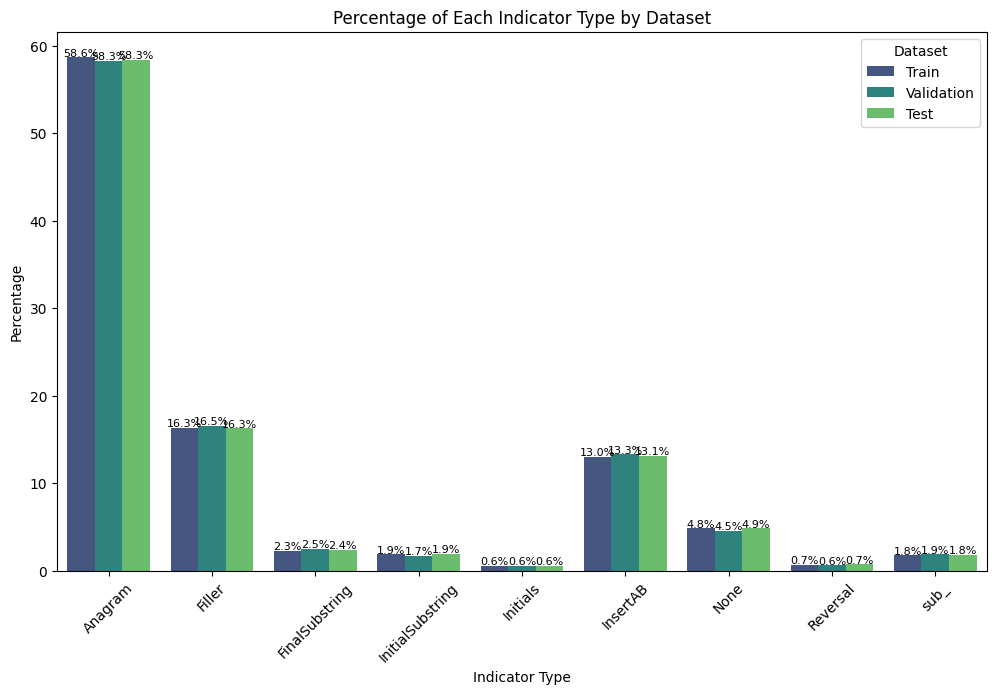

In [ ]:
# Fill None values with a placeholder
df_train['indicator'].fillna('None', inplace=True)
df_val['indicator'].fillna('None', inplace=True)
df_test['indicator'].fillna('None', inplace=True)

# Count occurrences of each indicator type including None
indicator_counts_train = df_train['indicator'].value_counts()
indicator_counts_val = df_val['indicator'].value_counts()
indicator_counts_test = df_test['indicator'].value_counts()

# Create a DataFrame to hold counts
counts_df = pd.DataFrame({
    'indicator': indicator_counts_train.index.union(indicator_counts_val.index).union(indicator_counts_test.index),
    'train': indicator_counts_train.reindex(indicator_counts_train.index.union(indicator_counts_val.index).union(indicator_counts_test.index), fill_value=0),
    'val': indicator_counts_val.reindex(indicator_counts_train.index.union(indicator_counts_val.index).union(indicator_counts_test.index), fill_value=0),
    'test': indicator_counts_test.reindex(indicator_counts_train.index.union(indicator_counts_val.index).union(indicator_counts_test.index), fill_value=0)
})

# Calculate percentage
total_train = counts_df['train'].sum()
total_val = counts_df['val'].sum()
total_test = counts_df['test'].sum()

counts_df['train_pct'] = (counts_df['train'] / total_train) * 100
counts_df['val_pct'] = (counts_df['val'] / total_val) * 100
counts_df['test_pct'] = (counts_df['test'] / total_test) * 100

# Melt the DataFrame for easy plotting with seaborn
melted_counts_df = counts_df.melt(id_vars='indicator', var_name='Dataset', value_name='Percentage')

# Map dataset to the percentage columns
melted_counts_df['Dataset'] = melted_counts_df['Dataset'].map({
    'train_pct': 'Train',
    'val_pct': 'Validation',
    'test_pct': 'Test'
})

# Plotting
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='indicator', y='Percentage', hue='Dataset', data=melted_counts_df, palette="viridis")

# Add percentage annotations with smaller font size and avoid 0.0%
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than 0
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='center',
                    xytext=(0, 3),
                    textcoords="offset points",
                    fontsize=8)  # Adjust font size here

plt.title("Percentage of Each Indicator Type by Dataset")
plt.xlabel("Indicator Type")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.show()

<ipython-input-133-f4f23d4b72f9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=indicator_counts.index, y=indicator_counts.values, palette="viridis")
<ipython-input-133-f4f23d4b72f9>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = indicator_percentages[i]


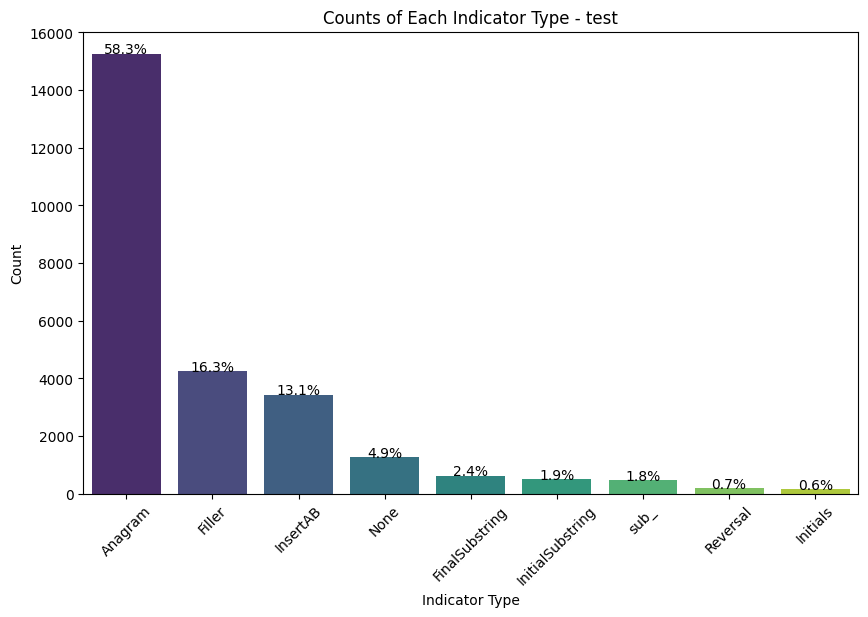

In [ ]:

# Fill None values with a placeholder
df_test['indicator'].fillna('None', inplace=True)

# Count occurrences of each indicator type including None
indicator_counts = df_test['indicator'].value_counts()

# Calculate percentages
indicator_percentages = indicator_counts / indicator_counts.sum() * 100

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=indicator_counts.index, y=indicator_counts.values, palette="viridis")

# Add percentage annotations
for i, count in enumerate(indicator_counts):
    percentage = indicator_percentages[i]
    plt.text(i, count + 0.1, f'{percentage:.1f}%', ha='center')

plt.title("Counts of Each Indicator Type - test")
plt.xlabel("Indicator Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(df_train.head(20))

   publisher       date author  number orientation  \
0      Times 2000-10-16              6      across   
1      Times 2000-10-16             11      across   
2      Times 2000-10-16             12      across   
3      Times 2000-10-16             13      across   
4      Times 2000-10-16             14      across   
5      Times 2000-10-16             17      across   
6      Times 2000-10-16             18      across   
7      Times 2000-10-16             19      across   
8      Times 2000-10-16             24      across   
9      Times 2000-10-16             25      across   
10     Times 2000-10-16             26      across   
11     Times 2000-10-16             27      across   
12     Times 2000-10-16              1        down   
13     Times 2000-10-16              2        down   
14     Times 2000-10-16              3        down   
15     Times 2000-10-16              4        down   
16     Times 2000-10-16              5        down   
17     Times 2000-10-16     